# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
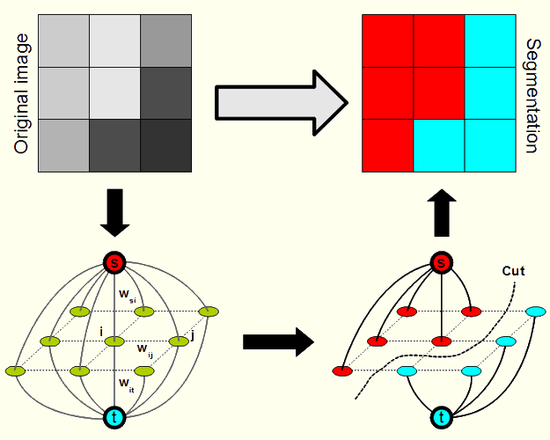

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [3]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import sys
import glob
import igraph as ig
from matplotlib import pyplot as plt
import random
import os

In [4]:
COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }
DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
DRAW_PR_FG = {'color': COLORS['GREEN'], 'val': 3}
DRAW_PR_BG = {'color': COLORS['RED'], 'val': 2}

In [5]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over']==False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over']==False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

## Class for gmm

In [6]:
class GaussianMixture:
    def __init__(self, X, n_components=5):
        self.n_components = n_components
        self.n_features = X.shape[1]
        self.n_samples = np.zeros(self.n_components)

        self.coefs = np.zeros(self.n_components)
        self.means = np.zeros((self.n_components, self.n_features))
       
        self.covariances = np.zeros((self.n_components, self.n_features, self.n_features))
        self.init_with_kmeans(X)
#         print("GM :")
#         print (self.coefs,self.means,self.covariances)

    def init_with_kmeans(self, X):
        label = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
        self.fit(X, label)

    def calc_score(self, X, ci):
        score = np.zeros(X.shape[0])
        
        if self.coefs[ci] > 0:
            diff = X - self.means[ci]
            mult = np.einsum('ij,ij->i', diff, np.dot(np.linalg.inv(self.covariances[ci]), diff.T).T)
            score = np.exp(-.5 * mult) / np.sqrt(2 * np.pi) / np.sqrt(np.linalg.det(self.covariances[ci]))
        
        return score

    def calc_prob(self, X):
        prob = [self.calc_score(X, ci) for ci in range(self.n_components)]
        
        return np.dot(self.coefs, prob)

    def which_component(self, X):
        prob = np.array([self.calc_score(X, ci) for ci in range(self.n_components)]).T

        return np.argmax(prob, axis=1)

    def fit(self, X, labels):
        assert self.n_features == X.shape[1]

        self.n_samples[:] = 0
        self.coefs[:] = 0

        uni_labels, count = np.unique(labels, return_counts=True)
        self.n_samples[uni_labels] = count

        variance = 0.01
        for ci in uni_labels:
            n = self.n_samples[ci]

            self.coefs[ci] = n / np.sum(self.n_samples)
            self.means[ci] = np.mean(X[ci == labels], axis=0)
            self.covariances[ci] = 0 if self.n_samples[ci] <= 1 else np.cov(X[ci == labels].T)

            det = np.linalg.det(self.covariances[ci])
            if det <= 0:
                self.covariances[ci] += np.eye(self.n_features) * variance
                det = np.linalg.det(self.covariances[ci])

In [7]:
class GrabCut:
    def __init__(self, img, mask,num_iters, gamma,gmm_components,flag,rect=None):
        self.img = np.asarray(img, dtype=np.float64)
        self.rows=img.shape[0] 
        self.cols=img.shape[1]

        self.mask = mask
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3],rect[0]:rect[0] + rect[2]] = DRAW_PR_FG['val']
        
        self.classify_pixels()

        # Best number of GMM components K suggested in paper
        self.gmm_components = gmm_components
        
        # Best gamma suggested in paper formula (5)
        self.gamma = gamma 
        
        self.beta = 0

        self.left_V = np.empty((self.rows, self.cols - 1))
        self.upright_V = np.empty((self.rows - 1, self.cols - 1))
        
        if flag==8:
            self.upleft_V = np.empty((self.rows - 1, self.cols - 1))
            self.up_V = np.empty((self.rows - 1, self.cols))

        self.bgd_gmm = None
        self.fgd_gmm = None
        self.comp_idxs = np.empty((self.rows, self.cols), dtype=np.uint32)

        self.gc_graph = None
        self.gc_graph_capacity = None           # Edge capacities
        self.gc_source = self.cols * self.rows  # "object" terminal S
        self.gc_sink = self.gc_source + 1       # "background" terminal T

        self.calc_beta_smoothness(8)
        self.init_GMMs()
        self.run(num_iters)

    def expectation_over_image(self,flag=8):
        x=0.0
        if flag==2:
            _left_diff = self.img[:, 1:] - self.img[:, :-1]
            _up_diff = self.img[1:, :] - self.img[:-1, :]
            return (_left_diff,_up_diff,np.sum(np.square(_left_diff)) + np.sum(np.square(_up_diff)))
        if flag==8:
            _left_diff = self.img[:, 1:] - self.img[:, :-1]
            _up_diff = self.img[1:, :] - self.img[:-1, :]
            _upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1]
            _upright_diff = self.img[1:, :-1] - self.img[:-1, 1:] 
            return (_left_diff,_up_diff,_upleft_diff,_upright_diff,np.sum(np.square(_left_diff)) + np.sum(np.square(_upleft_diff)) + \
                np.sum(np.square(_up_diff)) + np.sum(np.square(_upright_diff)))
#         return x
    
    def calc_beta_smoothness(self,flag):
        expect=self.expectation_over_image()
        if flag==8:
            self.beta = 1 / (2 * expect[4] / (4 * self.cols * self.rows- 3 * self.cols- 3 * self.rows + 2))  
        else:
            self.beta = 1 / (2 * expect[2] / (2 * self.cols * self.rows- self.cols- self.rows))
        print('Beta:', self.beta)

        # Smoothness term V described in formula (11)
        self.left_V = self.gamma * np.exp(-self.beta * np.sum(np.square(expect[0]), axis=2))
        self.up_V = self.gamma * np.exp(-self.beta * np.sum(np.square(expect[1]), axis=2))
        
        if flag==8:
            self.upleft_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(expect[2]), axis=2))
            self.upright_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(expect[3]), axis=2))


    def classify_pixels(self):
        self.bgd_indexes = np.where(np.logical_or(self.mask == DRAW_BG['val'], self.mask == DRAW_PR_BG['val']))
        self.fgd_indexes = np.where(np.logical_or(self.mask == DRAW_FG['val'], self.mask == DRAW_PR_FG['val']))

        assert self.bgd_indexes[0].size > 0
        assert self.fgd_indexes[0].size > 0

        print('(pr_)bgd count: %d, (pr_)fgd count: %d' % (self.bgd_indexes[0].size, self.fgd_indexes[0].size))

    def init_GMMs(self):
        self.bgd_gmm = GaussianMixture(self.img[self.bgd_indexes],self.gmm_components)
        self.fgd_gmm = GaussianMixture(self.img[self.fgd_indexes],self.gmm_components)

    def assign_GMMs_components(self):
        #Step 1 in Figure 3: Assign GMM components to pixels
        self.comp_idxs[self.bgd_indexes] = self.bgd_gmm.which_component(self.img[self.bgd_indexes])
        self.comp_idxs[self.fgd_indexes] = self.fgd_gmm.which_component(self.img[self.fgd_indexes])

    def learn_GMMs(self):
        #Step 2 in Figure 3: Learn GMM parameters from data z
        self.bgd_gmm.fit(self.img[self.bgd_indexes],self.comp_idxs[self.bgd_indexes])
        self.fgd_gmm.fit(self.img[self.fgd_indexes],self.comp_idxs[self.fgd_indexes])
    
    
    def create_pair(self,x,y):
        x1=[x]*y.size
        f=[(x1[i],y[i]) for i in range(0,len(y))]
        return f
    
    def construct_gc_graph(self,flag=8):
        self.gc_graph = ig.Graph(self.cols * self.rows + 2)
        edges = []
        self.gc_graph_capacity = []
        bgd_indexes = np.where(self.mask.reshape(-1) == DRAW_BG['val'])
        fgd_indexes = np.where(self.mask.reshape(-1) == DRAW_FG['val'])
        pr_indexes = np.where(np.logical_or(self.mask.reshape(-1) == DRAW_PR_BG['val'], self.mask.reshape(-1) == DRAW_PR_FG['val']))

#         print('bgd count: %d, fgd count: %d, uncertain count: %d' % (len(bgd_indexes[0]), len(fgd_indexes[0]), len(pr_indexes[0])))

        
#         Link from source & sink to remaining pixels
        # t-links
        edges.extend(self.create_pair(self.gc_source,pr_indexes[0]))
        _D = -np.log(self.bgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
#         assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(self.create_pair(self.gc_sink,pr_indexes[0]))
        _D = -np.log(self.fgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
#         assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(self.create_pair(self.gc_source,bgd_indexes[0]))
        self.gc_graph_capacity.extend([0] * bgd_indexes[0].size)
#         assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(self.create_pair(self.gc_sink,bgd_indexes[0]))
        self.gc_graph_capacity.extend([9 * self.gamma] * bgd_indexes[0].size)
#         assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(self.create_pair(self.gc_source,fgd_indexes[0]))
        self.gc_graph_capacity.extend([9 * self.gamma] * fgd_indexes[0].size)
#         assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(self.create_pair(self.gc_sink,fgd_indexes[0]))
        self.gc_graph_capacity.extend([0] * fgd_indexes[0].size)
#         assert len(edges) == len(self.gc_graph_capacity)

        # n-links
        img_indexes = np.arange(self.rows * self.cols,dtype=np.uint32).reshape(self.rows, self.cols)

        mask1 = img_indexes[:, 1:].reshape(-1)
        mask2 = img_indexes[:, :-1].reshape(-1)
#         edges.extend(list(zip(mask1, mask2)))
        edges.extend([(mask1[i],mask2[i]) for i in range(0,min(len(mask1),len(mask2)))])
        self.gc_graph_capacity.extend(self.left_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, :].reshape(-1)
        mask2 = img_indexes[:-1, :].reshape(-1)
#         edges.extend(list(zip(mask1, mask2)))
        edges.extend([(mask1[i],mask2[i]) for i in range(0,min(len(mask1),len(mask2)))])
        self.gc_graph_capacity.extend(self.up_V.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)
        
        if flag==8:
        
            mask1 = img_indexes[1:, 1:].reshape(-1)
            mask2 = img_indexes[:-1, :-1].reshape(-1)
#             edges.extend(list(zip(mask1, mask2)))
            edges.extend([(mask1[i],mask2[i]) for i in range(0,min(len(mask1),len(mask2)))])
            self.gc_graph_capacity.extend(self.upleft_V.reshape(-1).tolist())
            assert len(edges) == len(self.gc_graph_capacity)

            mask1 = img_indexes[1:, :-1].reshape(-1)
            mask2 = img_indexes[:-1, 1:].reshape(-1)
#             edges.extend(list(zip(mask1, mask2)))
            edges.extend([(mask1[i],mask2[i]) for i in range(0,min(len(mask1),len(mask2)))])
            self.gc_graph_capacity.extend(self.upright_V.reshape(-1).tolist())
            assert len(edges) == len(self.gc_graph_capacity)
            
            assert len(edges) == 4 * self.cols * self.rows - 3 * (self.cols + self.rows) + 2 +2 * self.cols * self.rows
            
            
        else:
            assert len(edges) == 2 * self.cols * self.rows - (self.cols + self.rows) + 2* self.cols * self.rows

        self.gc_graph.add_edges(edges)

    def estimate_segmentation(self):
        mincut = self.gc_graph.st_mincut(self.gc_source, self.gc_sink, self.gc_graph_capacity)
        pr_indexes = np.where(np.logical_or(self.mask == DRAW_PR_BG['val'], self.mask == DRAW_PR_FG['val']))
        img_indexes = np.arange(self.rows * self.cols, dtype=np.uint32).reshape(self.rows, self.cols)
        self.mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),DRAW_PR_FG['val'], DRAW_PR_BG['val'])
        self.classify_pixels()
        
    def run(self, num_iters=1,skip_learn_GMMs=False):
        for _ in range(num_iters):
            if not skip_learn_GMMs:
                self.assign_GMMs_components()
                self.learn_GMMs()
            self.construct_gc_graph()
            self.estimate_segmentation()
            skip_learn_GMMs=False
        print("run complete")
#         print(self.mask)

In [11]:
def run(filename: str,out:str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
    DRAW_PR_FG = {'color': COLORS['GREEN'], 'val': 3}
    DRAW_PR_BG = {'color': COLORS['RED'], 'val': 2}
    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
#     print(img.shape[0])
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            bar = np.zeros((img.shape[0], 5, 3), np.uint8)
            res = np.hstack((img2, bar, img, bar, output))
            cv2.imwrite('../images/result/seg_10_'+out, res)
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            skip_learn_GMMs = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            print("Started Segmentation")
            print(FLAGS['RECT'])
            if (FLAGS['rect_or_mask'] == 0):         # grabcut with rect
                gc = GrabCut(img2, mask, 10,50,5,8, FLAGS['RECT'])
                FLAGS['rect_or_mask'] = 1
            elif FLAGS['rect_or_mask'] == 1:         # grabcut with mask
                gc.run(skip_learn_GMMs=FLAGS['rect_or_mask'])
                skip_learn_GMMs = False
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#

        EventObj.flags = FLAGS
        mask2 = np.where((mask == 1)+ (mask == 3), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

In [12]:
if __name__ == '__main__':
    path = '../images/' 
    files=os.listdir(path)
    files=['banana3.jpg']
    random.shuffle(files)
    for i in range(0,len(files)):
        run(path+files[i],files[i])
        
    cv2.destroyAllWindows()

Draw the rectangle first.
Started Segmentation
(35, 69, 598, 351)
(pr_)bgd count: 97302, (pr_)fgd count: 209898
Beta: 0.0012620448988959444
(pr_)bgd count: 165394, (pr_)fgd count: 141806
(pr_)bgd count: 201752, (pr_)fgd count: 105448
(pr_)bgd count: 212155, (pr_)fgd count: 95045
(pr_)bgd count: 216301, (pr_)fgd count: 90899
(pr_)bgd count: 216342, (pr_)fgd count: 90858
(pr_)bgd count: 216340, (pr_)fgd count: 90860
(pr_)bgd count: 216336, (pr_)fgd count: 90864
(pr_)bgd count: 216335, (pr_)fgd count: 90865
(pr_)bgd count: 216354, (pr_)fgd count: 90846
(pr_)bgd count: 216351, (pr_)fgd count: 90849
run complete


## The number of iterations of GMM updating and energy minimization

- Because GMM parameters get fine-tuned in successive iterations and energy is also minimized,with increase in iterations, the extracted foreground becomes better and borders get neater. But beyond a threshold increase in iterations doesnt matter as the energy becomes constant.
- Tried for 1 , 5 , 10 iterations

**1 iteration**

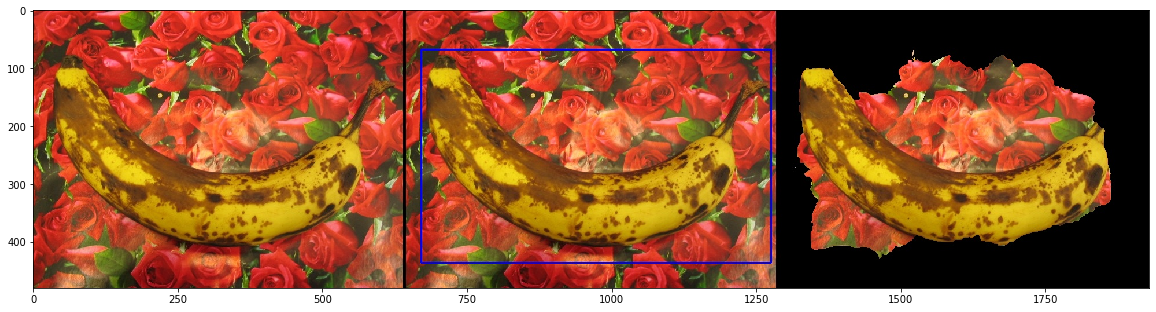

In [19]:
x=cv2.imread('../images/result/seg_1_banana3.jpg')
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.show()

**5 iteration**

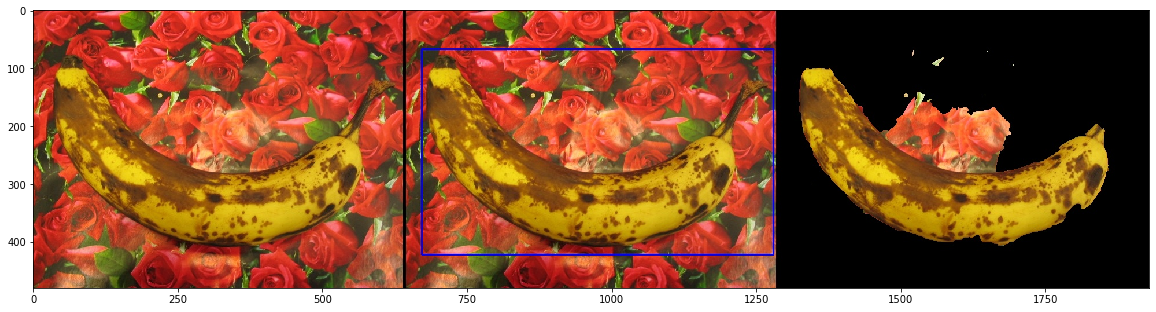

In [20]:
x=cv2.imread('../images/result/seg_5_banana3.jpg')
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.show()

**10 iteration**

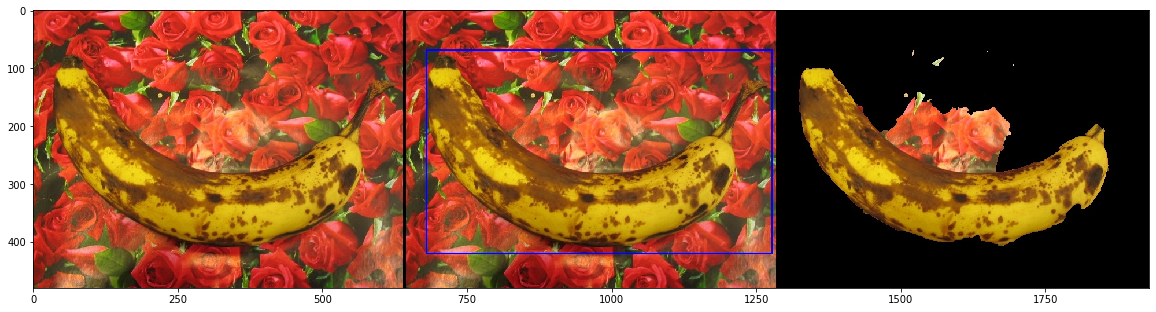

In [21]:
x=cv2.imread('../images/result/seg_10_banana3.jpg')
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.show()

## The number of mixture components in your GMM

- The paper suggests 5 GMM components to be used. Changing the number of components shows bad results for fewer components(tested for 3) and similar results for 5,10 GMM components. The number of components used must be able to capture the information in the foreground/background adequately.